# Métodos basados en datos

## Bivariados
En los métodos bivariados cada mapa factor (geología, pendiente, coberturas, etc) es combinado con el inventario de movimientos en masa, para obtener los pesos de las clases que conforman las variables, basados generalmente en densidad de movimientos en masa. Los métodos estadísticos bivariados son una buena herramienta de aprendizaje para el analista encontrar qué factores o combinación de factores juegan un papel importante en la ocurrencia de movimientos en masa. 

Como se mencionó anteriormente, estos métodos están basados en la asociación observada entre la distribución de los movimientos en masa y cada clase de la variable, lo que exige que cada variable sea transforamda a una variable categórica dividida por clases. De esta misma forma los métodos bivariados sólo permiten asignar peso a las clases y no a las variables, por lo que todas las variables tienen una importancia igual sobre la ocurrencia de movimientos en masa. Considerando esta desventaja, es muy común combinar los métodos estadísticos bivariados con métodos heurísticos como AHP para poder asignar peso a las variables.

Existe una gran cantidad de métodos estadísticos bivariados, los cuales se subdividen esencialmente en métodos basados en la densidad del número de movimientos en masa en cada clase (*Frequency ratio*, *Statistical index*), y los métodos basados en el teorema de Bayes (*Weight-of-evidence*, *Evidential belief function*,  *Certainty factor*).

### *Frequency ratio model* (*Likelihood*)
Este método, al igual que todos los métodos bivariados, calcula un peso para cada clase en la cual es dividida cada variable. En este caso el peso de la clase n ($w_n$) se calcula dividiendo la relación de la ocurrencia de movimientos en masa ($L_r$) por la relación del área de la clase ($A_r$):

$w_n = \frac{L_r}{A_r}$

Donde $L_r$ es el porcentaje de movimientos en masa total que contiene la clase $n$, y $A_r$ es el porcentaje del área total de representa dicha clase:

$L_r = \frac{L_{clase}}{L_{total}}$

$A_r = \frac{A_{clase}}{A_{total}}$

Finalmente, la susceptibilidad de una celda es igual a la sumatoria del peso de cada clase ($w$) a la que pertenece en cada variable:

$S^n = \sum w = w_{pendiente} + w_{geologia} + w_{coberturas} + ...w_{n} $

:::{figure-md} likehood
<img src="https://www.researchgate.net/profile/Jangwon-Suh-3/publication/303875920/figure/fig1/AS:371153064480768@1465501194778/Example-for-calculating-frequency-ratio-using-raster-grids-modified-from-Oh-et-al.png" alt="likehood" width="600px">

Método de *Frequency ratio*. Tomado de Suh et al. (2015)
:::

#### *Python*

En el presente ejemplo, y solo con propósitos pedagógicos, se utilizarán solo tres variables (pendiente, geologia, aspecto) pero el procedimiento señalado se debera utilizar para todas las variables incorporadas en el modelo de susceptibilidad.

Inicialmente se procede a importar las librerías a utilizar:

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

A continuación se importa el inventario de movimientos en masa, así como los mapas de las variables predictoras a utilizar:

(548839,)

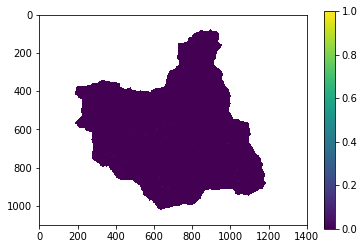

In [ ]:
raster = rio.open('https://github.com/dahiginioj/Cartograf-a-Geotecnica-2022-ll/blob/main/Taller4/Inventario.tif?raw=true')
inventario=raster.read(1)
raster_mask = rio.open('https://github.com/dahiginioj/Cartograf-a-Geotecnica-2022-ll/blob/main/Taller5/Pendiente1.tif?raw=true')
msk=raster_mask.read_masks(1)
msk=np.where(msk==255,1,np.nan)
inventario=msk*inventario
inventario_vector=inventario.ravel()
inventario_vector_MenM=inventario_vector[~np.isnan(inventario_vector)]
plt.imshow(inventario)
plt.colorbar()
inventario_vector_MenM.shape

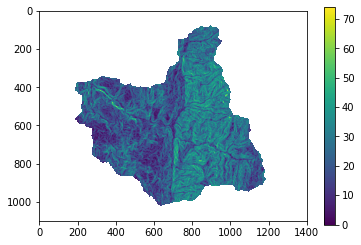

In [ ]:
raster = rio.open('https://github.com/dahiginioj/Cartograf-a-Geotecnica-2022-ll/blob/main/Taller5/Pendiente1.tif?raw=true')
pendiente=raster.read(1)
pendiente=np.where(pendiente<0,np.nan,pendiente)
plt.imshow(pendiente);
plt.colorbar();
pendiente_vector=pendiente.ravel()
pendiente_vector_MenM=pendiente_vector[~np.isnan(pendiente_vector)]

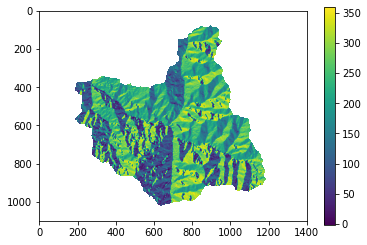

In [ ]:
raster = rio.open('https://github.com/dahiginioj/Cartograf-a-Geotecnica-2022-ll/blob/main/Taller5/Aspecto.tif?raw=true')
aspecto=raster.read(1)
aspecto=np.where(aspecto<-1,np.nan,aspecto)
aspecto_vector=aspecto.ravel()
aspecto_vector_MenM=aspecto_vector[~np.isnan(aspecto_vector)]
plt.imshow(aspecto)
plt.colorbar()

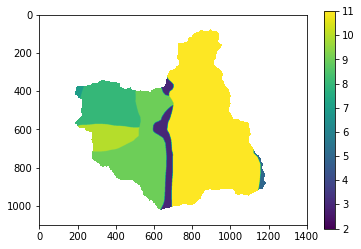

In [ ]:
raster = rio.open('https://github.com/dahiginioj/Cartograf-a-Geotecnica-2022-ll/blob/main/Taller5/MapaGeo.tif?raw=true')
geologia=raster.read(1)
geologia=np.where(geologia>11,np.nan,geologia)
geologia_vector=geologia.ravel()
geologia_vector_MenM=geologia_vector[~np.isnan(geologia_vector)]
plt.imshow(geologia)
plt.colorbar();

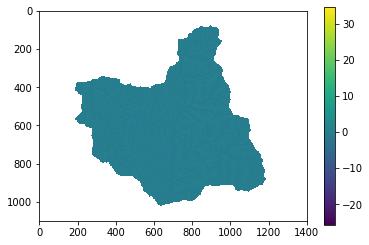

In [ ]:
raster = rio.open('https://github.com/dahiginioj/Cartograf-a-Geotecnica-2022-ll/blob/main/Taller5/Curvatura1.tif?raw=true')
curvatura=raster.read(1)
curvatura=np.where(curvatura<-25.6,np.nan,curvatura)
curvatura_vector=curvatura.ravel()
curvatura_vector_MenM=curvatura_vector[~np.isnan(curvatura_vector)]
plt.imshow(curvatura)
plt.colorbar()

Para implementar todos lo métodos estadísticos bivariados se deben conocer para cada clase de las variables, el número de celdas que pertenecen a dicha clase y el número de celdas con MenM.

A continuación se presenta el procedimiento para el mapa de pendiente, el cual es una variable continua. Como se mencionó anteriormente en los metodos estadísticos bivariados se deben transformar las variables continuas a categóricas. En este caso el mapa de pendientes se convierte a 5 clases [0-10, 10-20, 20-30, 30-35, >35]. 

Para realizar este procedimiento se utiliza el vector que se generó con el mapa de pendiente, y se convierte a una serie de Pandas, de tal forma que permita iterar.

In [ ]:
pendiente_serie=pd.Series(pendiente_vector_MenM)
ap=bp=cp=dp=ep=0
for row in pendiente_serie:
        if (0 <= row) & (row < 10):
          ap+=1
        elif (10 <= row) & (row < 20):
          bp+=1
        elif (20 <= row) & (row < 30):
          cp+=1
        elif (30 <= row) & (row < 35):
          dp+=1
        if (row>=35):
          ep+=1

totalp=ap+bp+cp+dp+ep
print("total:", totalp,ap,bp,cp,dp,ep)

pendienteconMenM=pendiente_vector_MenM*inventario_vector_MenM
ap1=bp1=cp1=dp1=ep1=0
for row in pendienteconMenM:
        if (0 < row) & (row < 10):
          ap1+=1
        elif (10 <= row) & (row < 20):
          bp1+=1
        elif (20 <= row) & (row < 30):
          cp1+=1
        elif (30 <= row) & (row < 35):
          dp1+=1
        if (row>=35):
          ep1+=1

total1p=ap1+bp1+cp1+dp1+ep1
print("total1:", total1p,ap1,bp1,cp1,dp1,ep1)

total: 548839 52045 149394 180074 74696 92630
total1: 74 3 18 35 10 8


Ahora se calcula el *Frequency ratio* para cada clase a partir de los valores estimados previamente:

In [ ]:
w_a=(ap1/total1p)/(ap/totalp)
w_b=(bp1/total1p)/(bp/totalp)
w_c=(cp1/total1p)/(cp/totalp)
w_d=(dp1/total1p)/(dp/totalp)
w_e=(ep1/total1p)/(ep/totalp)
print(w_a,w_b,w_c,w_d,w_e)

0.42751906484253493 0.8936194116121021 1.441551881523782 0.9929237500325644 0.6405478348909203


Finalmente se reclasifica el mapa, asignándole a cada clase el valor del *Frequency ratio* calculado:

[0.42751905 0.6405478  0.8936194  0.99292374 1.4415519         nan]


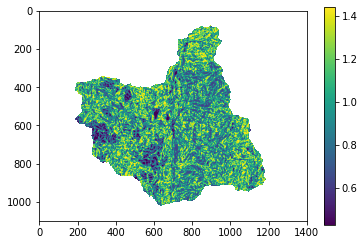

In [ ]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),w_a,pendiente )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),w_b,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),w_c,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=30, pendiente_c<35 )),w_d,pendiente_c )
pendiente_c=np.where ( pendiente_c>=35,w_e,pendiente_c )

plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Ahora se realiza el mismo procedimiento para la variable *aspecto*, la cual tambien es continua, en este caso se divide en 4 clases [0-90, 90-180, 180-270, 270-360]:

total: 548839 236 114810 110593 149717 173483
total1: 74 0 27 12 15 20
w: 0.0 1.7442040551133835 0.8047608702080505 0.743076261537759 0.8550397725705969
[0.74307626 0.8047609  0.8550398  1.744204          nan]


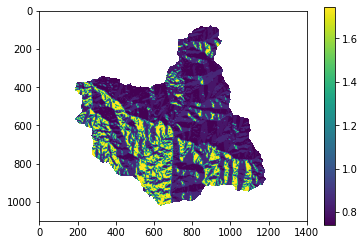

In [ ]:
aspecto_serie=pd.Series(aspecto_vector_MenM)
aa=ba=ca=da=ea=0
for row in aspecto_serie:
        if (-1 <= row) & (row < 0):
          aa+=1
        if (0 <= row) & (row < 90):
          ba+=1
        elif (90 <= row) & (row < 180):
          ca+=1
        elif (180 <= row) & (row < 270):
          da+=1
        if (row>=270):
          ea+=1

totala=aa+ba+ca+da+ea
print("total:", totala,aa,ba,ca,da,ea)

aspectoconMenM=aspecto_vector_MenM*inventario_vector_MenM
aa1=ba1=ca1=da1=ea1=0
for row in aspectoconMenM:
        if (-1 < row) & (row < 0):
          aa1+=1
        elif (0 < row) & (row < 90):
          ba1+=1
        elif (90 <= row) & (row < 180):
          ca1+=1
        elif (180 <= row) & (row < 270):
          da1+=1
        if (row>=270):
          ea1+=1

total1a=aa1+ba1+ca1+da1+ea1
print("total1:", total1a,aa1,ba1,ca1,da1,ea1)

w_a=(aa1/total1a)/(aa/totala)
w_b=(ba1/total1a)/(ba/totala)
w_c=(ca1/total1a)/(ca/totala)
w_d=(da1/total1a)/(da/totala)
w_e=(ea1/total1a)/(ea/totala)
print("w:", w_a,w_b,w_c,w_d,w_e)

aspecto_c=np.where ( (np.logical_and (aspecto>=-1, aspecto<0 )),w_a,aspecto )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=0, aspecto_c<90 )),w_b,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=90, aspecto_c<180 )),w_c,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=180, aspecto_c<270 )),w_d,aspecto_c )
aspecto_c=np.where ( aspecto_c>=270,w_e,aspecto_c )

plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

Y el mismo procedimiento para la variable *geologia*, la cual es categórica por lo cual ligeramente varía el procedimiento.

total 548839 2 25648 5079 2694 66392 116346 30661 302017
total1 74 0 14 0 0 1 27 4 28
w: 0.0 4.048440634958102 0.0 0.0 0.11171139961506271 1.7211770715586918 0.9675800845690934 0.6876063625915456
[0.         0.1117114  0.68760636 0.96758008 1.72117707 4.04844063
        nan]


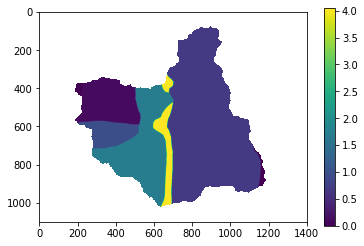

In [ ]:
ag=(geologia == 2).sum()
bg=(geologia == 3).sum()
cg=(geologia == 5).sum()
dg=(geologia == 7).sum()
eg=(geologia == 8).sum()
fg=(geologia == 9).sum()
gg=(geologia == 10).sum()
hg=(geologia == 11).sum()

totalg=ag+bg+cg+dg+eg+fg+gg+hg
print("total", totalg,ag,bg,cg,dg,eg,fg,gg,hg)

geologiaconMenM=geologia*inventario
ag1=(geologiaconMenM == 2).sum()
bg1=(geologiaconMenM == 3).sum()
cg1=(geologiaconMenM == 5).sum()
dg1=(geologiaconMenM == 7).sum()
eg1=(geologiaconMenM == 8).sum()
fg1=(geologiaconMenM == 9).sum()
gg1=(geologiaconMenM == 10).sum()
hg1=(geologiaconMenM == 11).sum()


totalg1=ag1+bg1+cg1+dg1+eg1+fg1+gg1+hg1
print("total1", totalg1,ag1,bg1,cg1,dg1,eg1,fg1,gg1,hg1)

w_a=(ag1/totalg1)/(ag/totalg)
w_b=(bg1/totalg1)/(bg/totalg)
w_c=(cg1/totalg1)/(cg/totalg)
w_d=(dg1/totalg1)/(dg/totalg)
w_e=(eg1/totalg1)/(eg/totalg)
w_f=(fg1/totalg1)/(fg/totalg)
w_g=(gg1/totalg1)/(gg/totalg)
w_h=(hg1/totalg1)/(hg/totalg)
print("w:", w_a,w_b,w_c,w_d,w_e,w_f,w_g,w_h)

geologia_c=np.where ( geologia==2,w_a,geologia )
geologia_c=np.where ( geologia_c==3,w_b,geologia_c )
geologia_c=np.where ( geologia_c==5,w_c,geologia_c )
geologia_c=np.where ( geologia_c==7,w_d,geologia_c )
geologia_c=np.where ( geologia_c==8,w_e,geologia_c )
geologia_c=np.where ( geologia_c==9,w_f,geologia_c  )
geologia_c=np.where ( geologia_c==10,w_g,geologia_c  )
geologia_c=np.where ( geologia_c==11,w_h,geologia_c  )

plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

total: 548839 614 75633 148996 318599 4997
total1: 60 0 5 13 41 1
w: 0.0 0.6047172971233896 0.7981094570771474 1.177153673844969 1.8305616703355347
[1.1771537 1.8305616       nan]


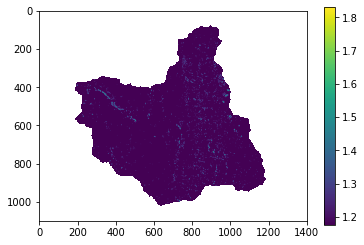

In [ ]:

curvatura_serie=pd.Series(curvatura_vector_MenM)
ac=bc=cc=dc=ec=0
for row in curvatura_serie:
        if (-25.60000038147 <= row) & (row < -7.4):
          ac+=1
        if (-7.4 <= row) & (row < -1.7):
          bc+=1
        elif (-1.7 <= row) & (row < 0):
          cc+=1
        elif (0 <= row) & (row < 4):
          dc+=1
        if (row>=4):
          ec+=1

totalc=ac+bc+cc+dc+ec
print("total:", totalc,ac,bc,cc,dc,ec)

curvaturaconMenM=curvatura_vector_MenM*inventario_vector_MenM
ac1=bc1=cc1=dc1=ec1=0
for row in curvaturaconMenM:
        if (-25.60000038147 <= row) & (row < -7.4):
          ac1+=1
        elif (-7.4 <= row) & (row < -1.7):
          bc1+=1
        elif (-1.7 <= row) & (row < 0):
          cc1+=1
        elif (0 < row) & (row < 4):
          dc1+=1
        if (row>=4):
          ec1+=1

total1c=ac1+bc1+cc1+dc1+ec1
print("total1:", total1c,ac1,bc1,cc1,dc1,ec1)

w_a=(ac1/total1c)/(ac/totalc)
w_b=(bc1/total1c)/(bc/totalc)
w_c=(cc1/total1c)/(cc/totalc)
w_d=(dc1/total1c)/(dc/totalc)
w_e=(ec1/total1c)/(ec/totalc)
print("w:", w_a,w_b,w_c,w_d,w_e)

curvatura_c=np.where ( (np.logical_and (curvatura>=-25.60000038147, curvatura<-7.4 )),w_a,curvatura )
curvatura_c=np.where ( (np.logical_and (curvatura_c>=-7.4, curvatura_c<-1.7 )),w_b,curvatura_c )
curvatura_c=np.where ( (np.logical_and (curvatura_c>=-1.7, curvatura_c<0 )),w_c,curvatura_c )
curvatura_c=np.where ( (np.logical_and (curvatura_c>=0, curvatura_c<4 )),w_d,curvatura_c )
curvatura_c=np.where ( curvatura_c>=4,w_e,curvatura_c )

plt.imshow(curvatura_c)
plt.colorbar()
print(np.unique(curvatura_c));

Con los mapas de cada variable reclasificados de acuerdo con el valor de *Frequency ratio* se procede entonces a sumar todas las variables y obtener el mapa de susceptibilidad:

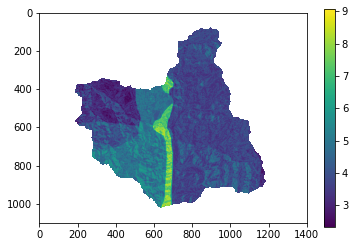

In [ ]:
IS=pendiente_c+geologia_c+curvatura_c+aspecto_c
plt.imshow(IS);
plt.colorbar();

In [ ]:
meta=raster.profile
raster_transform = meta['transform']
raster_crs = meta['crs']

with rio.open('IS.TIF', 'w', 
              driver='Gtiff',height=aspecto.shape[0],width=aspecto.shape[1],count=1,
              dtype='float64',nodata=-999,crs=raster_crs,transform=raster_transform) as dst:
    dst.write(IS,1);

### *Statistical index model*
El valor del peso para cada clase en el método *Statistical index model* es definido como el logaritmo natural de la densidad de movimientos en masa en una clase ($\rho_{clase}$) dividido la densidad de deslizamientos en toda la zona de estudio ($\rho_{total}$), de acuerdo con la siguiente ecuación:

$w_{ij}^n = \ln(\frac{\rho_{clase}}{\rho_{total}}) = \ln(\frac{\frac{N_{ij}}{S_{ij}}}{\frac{N}{S}}) $

Donde $w_{ij}^n$ es el peso de la celda $n$ que pertenece a la clase $i$ de la variable $j$. $\rho_{clase}$ es la densidad de deslizamientos de la clase $i$ del parámetro $j$, calculado a  partir de $N_{ij}$ como el número de pixeles con MenM en una cierta clase $i$ del parametro $j$, $S_{ij} como el número de pixeles de la clase $i$ del parametro $j$. N es el total de celdas que corresponden a deslizamientos en todo el mapa y S es el total de celdas del área de estudio.

Finalmente la susceptibilidad a movimientos en masa de cada celda es igual a:

$S^n = \sum w = w_{pendiente} + w_{geologia} + w_{coberturas} + ...w_{n} $

#### Python

Para el método de *Statistical index* se debe calcular la densidad de movimientos en masa, tanto para las clases de cada variable, como para el área total.

La densidad total es igual a:

In [ ]:
dt=total1/total
print(dt)

0.0017810045965309987


La densidad para las 5 clases de pendiente se estiman de la siguiente manera:

In [ ]:
w_a=np.log((ap1/ap)/dt)
w_b=np.log((bp1/bp)/dt)
w_c=np.log((cp1/cp)/dt)
w_d=np.log((dp1/dp)/dt)
w_e=np.log((ep1/ep)/dt)
print(w_a,w_b,w_c,w_d,w_e)

-1.9975946273658713 -0.8272443218321374 -0.19154372854191365 0.0672680287170693 0.4533616958660388


Con estos valores del *statistical index* se reclasifica el mapa de pendientes:

[-1.9975946  -0.82724434 -0.19154373  0.06726803  0.4533617          nan]


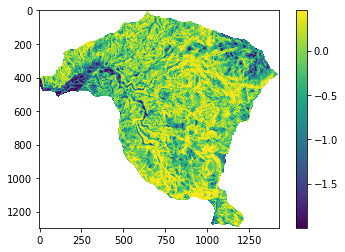

In [ ]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),w_a,pendiente )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),w_b,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),w_c,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=30, pendiente_c<35 )),w_d,pendiente_c )
pendiente_c=np.where ( pendiente_c>=35,w_e,pendiente_c )

plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Realizamos el mismo procedimiento para la variable *aspecto*:

w: 0.006933187278979516 0.5611974088841332 -0.1519361180824098 -0.18464209803578424
[-1.         -0.18464209 -0.15193611  0.00693319  0.5611974          nan]


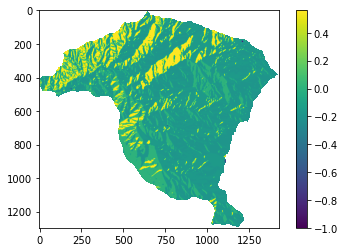

In [ ]:
w_a=np.log((aa1/aa)/dt)
w_b=np.log((ba1/ba)/dt)
w_c=np.log((ca1/ca)/dt)
w_d=np.log((da1/da)/dt)
print("w:", w_a,w_b,w_c,w_d)

aspecto_c=np.where ( (np.logical_and (aspecto>=0, aspecto<90 )),w_a,aspecto )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=90, aspecto_c<180 )),w_b,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=180, aspecto_c<270 )),w_c,aspecto_c )
aspecto_c=np.where ( aspecto_c>=270,w_d,aspecto_c )

plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

Para la variable geología se debe tener en cuenta que existen algunas clases que no presentan celdas con MenM, por lo tanto generan un error al calcular el logaritmo. Para superar est se le asigna un valor de 1 a dichas clases.

w: 0.36987982682432763 1.200678978884011 -1.695592501139342 0.5311140506574584 -4.205723000249289 0.07473838228040365 0.4625264091580406 -0.22131946592927398 1.3725861331962508 -3.499424769466566
[-4.205723   -3.49942477 -1.6955925  -0.22131947  0.07473838  0.36987983
  0.46252641  0.53111405  1.20067898  1.37258613         nan]


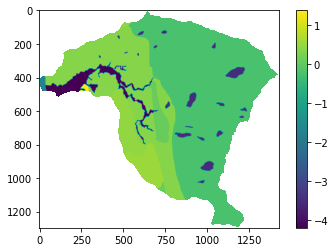

In [ ]:
bg1=cg1=eg1=jg1=1   #clases que obtuvieron 0 celdas con movimientos en masa

w_a=np.log((ag1/ag)/dt)
w_b=np.log((bg1/bg)/dt)
w_c=np.log((cg1/cg)/dt)
w_d=np.log((dg1/dg)/dt)
w_e=np.log((eg1/eg)/dt)
w_f=np.log((fg1/fg)/dt)
w_g=np.log((gg1/gg)/dt)
w_h=np.log((hg1/hg)/dt)
w_i=np.log((ig1/ig)/dt)
w_j=np.log((jg1/jg)/dt)
print("w:", w_a,w_b,w_c,w_d,w_e,w_f,w_g,w_h,w_i,w_j)

geologia_c=np.where ( geologia==2,w_a,geologia )
geologia_c=np.where ( geologia_c==4,w_b,geologia_c )
geologia_c=np.where ( geologia_c==6,w_c,geologia_c )
geologia_c=np.where ( geologia_c==8,w_d,geologia_c )
geologia_c=np.where ( geologia_c==9,w_e,geologia_c )
geologia_c=np.where ( geologia_c==10,w_f,geologia_c  )
geologia_c=np.where ( geologia_c==11,w_g,geologia_c  )
geologia_c=np.where ( geologia_c==14,w_h,geologia_c  )
geologia_c=np.where ( geologia_c==15,w_i,geologia_c  )
geologia_c=np.where ( geologia_c==16,w_j,geologia_c  )

plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Con los mapas de cada variable reclasificados de acuerdo con el valor de *Statistical index* se procede entonces a sumar todas las variables y obtener el mapa de susceptibilidad:

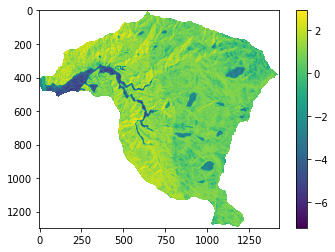

In [ ]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### Peso de la evidencia (WoE)
El Peso de la Evidencia, basado en la teoría de la probabilidad Bayesiana, analiza la relación entre las áreas afectadas 
por los movimientos en masa y la distribución espacial de los factores condicionantes del terreno. Este método arroja 
los pesos de las clases que conforman las variables condicionantes, indicando la presencia e influencia de la clase como parámetro 
en la ocurrencia del movimiento en masa. Los pesos positivos (W+)  indican la presencia de la clase como parámetro que 
favorece los movimientos en masa y su magnitud indica su correlación. El peso negativo (W-) indica la ausencia de la clase en la ocurrencia de 
movimiento en masa. 

Dónde $N_{pix1}$ es el número de pixeles con movimientos en masa ($S$) en la clase $B_i$, $N_{pix2}$ número de pixeles con movimientos 
en masa que no están presentes en la misma clase $\hat{B}_i$, $N_{pix3}$ es el número de pixeles en la clase que no hay movimientos 
en masa $\hat{S}$ y $N_{pix4}$ es el número de pixeles en la clase donde no hay movimientos en masa $\hat{S}$ y que no está presente en 
la clase  $\hat{B}_i$.

:::{figure-md} woe
<img src="https://i.pinimg.com/564x/70/a4/d5/70a4d5ecbab6d6bf9bdb0f914c91dba8.jpg" alt="woe" width="600px">

Método de Peso de la Evidencia.
:::

$C = W^+ - W^-$

Y el contraste C refleja el espacio de asociación respecto a la clase en la predicción del movimiento en masa, la cual 
es cero cuando la clase no afecta, es positivo cuando existe una correlación directa y negativo cuando existe una correlación inversa con la distribución de movimientos en masa.

#### Python

Para calcular el $W^+$ (wp), $W^-$ (wn), y $C$ de cada clase se utilizan las siguientes ecuaciones del método WoE: $N_{pix1}$=a1, son las celdas que pertenecen a la clase a y tienen MenM. $N_{pix2}$=total1-a1, son las celdas que no pertenecen a la clase a y que tienen MenM, $N_{pix3}$=a-a1, son las celdas que pertenecen a la clase a pero que no tienen MenM. y $N_{pix4}$=(b+c+d+e)-(b1+c1+d1+e1), son las celdas que no pertenecen a la clase a y que no tienen MenM.

In [ ]:
x1=ap1
x2=total1-ap1
x3=ap-ap1
x4=(bp+cp+dp+ep)-(bp1+cp1+dp1+ep1)

Con los valores de x1, x2, x3, x4 se calculan el $W^+$ (wp), el $W^-$ (Wn) y el Contraste de la siguiente forma:

In [ ]:
wp_a=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_a=np.log((x2/(x1+x2))/(x4/(x3+x4)))
c=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))
print(wp_a, wn_a, c)

-1.9978126337233664 0.05293079554963469 -2.0507434292730014


Con el valor del contraste para la clase $a$ del mapa de pendiente, se genera un mapa de pendiente reclasificado donde todas las celdas que pertenezcan a la clase a ahora tengan el valor del contraste de $a$.

In [ ]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),c,pendiente );

Ahora se repite el mismo procedimiento para cada una de las clases en las cuales se clasificó el mapa de pendientes.

In [ ]:
#Clase b
x1=bp1
x2=total1-bp1
x3=bp-bp1
x4=(ap+cp+dp+ep)-(ap1+cp1+dp1+ep1)

wp_b=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_b=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),cont,pendiente_c )

#Clase c
x1=cp1
x2=total1-cp1
x3=cp-cp1
x4=(ap+bp+dp+ep)-(ap1+bp1+dp1+ep1)

wp_c=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_c=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),cont,pendiente_c )

#Clase d
x1=dp1
x2=total1-dp1
x3=dp-dp1
x4=(ap+bp+cp+ep)-(ap1+bp1+cp1+ep1)

wp_d=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_d=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),cont,pendiente_c )

#Clase e
x1=ep1
x2=total1-ep1
x3=ep-ep1
x4=(ap+bp+cp+dp)-(ap1+bp1+cp1+dp1)

wp_e=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_e=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

pendiente_c=np.where (pendiente_c>=30,cont,pendiente_c)

Se procede a imprimir cada uno de los $W^+$ y $W^-$ para detectar valores infinitos que se obtienen de logaritmos de 0, es decir que provienen de clases donde algunos de los numeradores (x1, x2, x3, o x4) es 0.

In [ ]:
print(wp_a, wn_a, wp_b, wn_b, wp_c, wn_c, wp_d, wn_d, wp_e, wn_e)

-1.9978126337233664 0.05293079554963469 -0.8269249184231674 0.09637540215921472 -0.190531748869874 0.0740267315295358 0.06871512729071115 -0.015040700202127994 0.45570855845755603 -0.2969812410286435


A continuación se presenta el mapa de pendiente reclasificado por el Contraste (C)

[-2.0507433  -0.9233003   0.08375583  0.7526898          nan]


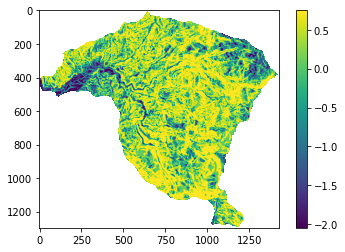

In [ ]:
plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Este mismo procedimiento se realiza para la variable *aspecto*.

In [ ]:
#Clase a
x1=aa1
x2=total1-aa1
x3=aa-aa1
x4=(ba+ca+da)-(ba1+ca1+da1)

wp_a=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_a=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where ((np.logical_and (aspecto>=0, aspecto<90 )),cont,aspecto )

#Clase b
x1=ba1
x2=total1-ba1
x3=ba-ba1
x4=(aa+ca+da)-(aa1+ca1+da1)

wp_b=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_b=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where ((np.logical_and (aspecto_c>=90, aspecto_c<180 )),cont,aspecto_c )

#Clase c
x1=ca1
x2=total1-ca1
x3=ca-ca1
x4=(aa+ba+da)-(aa1+ba1+da1)

wp_c=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_c=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where ((np.logical_and (aspecto_c>=180, aspecto_c<270 )),cont,aspecto_c )

#Clase d
x1=da1
x2=total1-da1
x3=da-da1
x4=(aa+ba+ca)-(aa1+ba1+ca1)

wp_d=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_d=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

aspecto_c=np.where (aspecto_c>=270,cont,aspecto_c )

In [ ]:
print(wp_a, wn_a, wp_b, wn_b, wp_c, wn_c, wp_d, wn_d)

0.006945600406864839 -0.0013894983310093806 0.5625413905302987 -0.13237052720363568 -0.15218757915959064 0.06932826692215219 -0.18494286273071125 0.08914131784141605


A continuación se presenta el mapa de aspecto reclasificado por el Contraste (C)

[-6.975576   -1.         -0.6254262  -0.29615796  2.4018128          nan]


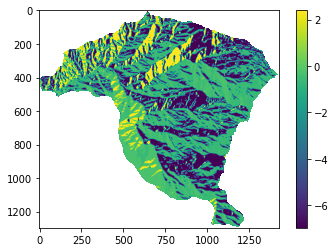

In [ ]:
plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

En el método *Peso de la evidencia* se debe tener en cuenta que las clases que no presentan movimientos en masa generan un matemático, ya que no se puede estimar el logaritmo natural de cero. Por lo tanto, se debe proceder a esas clases qdoden se obtuvo cero celdas asignarles un valor de 1, de tal forma que se pueda ejecutar el cálculo. 


In [ ]:
bg1=cg1=eg1=jg1=1   #clases que obtuvieron 0 celdas con movimientos en masa

#Clase a
x1=ag1
x2=total1-ag1
x3=ag-ag1
x4=(bg+cg+dg+eg+fg+gg+hg+ig+jg)-(bg1+cg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_a=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_a=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where(geologia==2,cont,geologia)

#Clase b
x1=bg1
x2=total1-bg1
x3=bg-bg1
x4=(ag+cg+dg+eg+fg+gg+hg+ig+jg)-(ag1+cg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_b=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_b=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==4,cont,geologia_c)

#Clase c
x1=cg1
x2=total1-cg1
x3=cg-cg1
x4=(ag+bg+dg+eg+fg+gg+hg+ig+jg)-(ag1+bg1+dg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_c=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_c=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==6,cont,geologia_c)

#Clase d
x1=dg1
x2=total1-dg1
x3=dg-dg1
x4=(ag+bg+cg+eg+fg+gg+hg+ig+jg)-(ag1+bg1+cg1+eg1+fg1+gg1+hg1+ig1+jg1)

wp_d=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_d=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==8,cont,geologia_c)

#Clase e
x1=eg1
x2=total1-eg1
x3=eg-eg1
x4=(ag+bg+cg+dg+fg+gg+hg+ig+jg)-(ag1+bg1+cg1+dg1+fg1+gg1+hg1+ig1+jg1)

wp_e=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_e=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==9,cont,geologia_c)

#Clase f
x1=fg1
x2=total1-fg1
x3=fg-fg1
x4=(ag+bg+cg+dg+eg+gg+hg+ig+jg)-(ag1+bg1+cg1+dg1+eg1+gg1+hg1+ig1+jg1)

wp_f=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_f=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==10,cont,geologia_c)

#Clase g
x1=gg1
x2=total1-gg1
x3=gg-gg1
x4=(ag+bg+cg+dg+fg+eg+hg+ig+jg)-(ag1+bg1+cg1+dg1+fg1+eg1+hg1+ig1+jg1)

wp_g=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_g=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==11,cont,geologia_c)

#Clase h
x1=hg1
x2=total1-hg1
x3=hg-hg1
x4=(ag+bg+cg+dg+fg+gg+eg+ig+jg)-(ag1+bg1+cg1+dg1+fg1+gg1+eg1+ig1+jg1)

wp_h=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_h=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==14,cont,geologia_c)

#Clase i
x1=ig1
x2=total1-ig1
x3=ig-ig1
x4=(ag+bg+cg+dg+fg+gg+hg+eg+jg)-(ag1+bg1+cg1+dg1+fg1+gg1+hg1+eg1+jg1)

wp_i=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_i=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==15,cont,geologia_c)

#Clase j
x1=jg1
x2=total1-jg1
x3=jg-jg1
x4=(ag+bg+cg+dg+fg+gg+hg+eg+ig)-(ag1+bg1+cg1+dg1+fg1+gg1+hg1+eg1+ig1)

wp_j=np.log((x1/(x1+x2))/(x3/(x3+x4)))
wn_j=np.log((x2/(x1+x2))/(x4/(x3+x4)))
cont=np.log(((x1/(x1+x2))/(x3/(x3+x4)))/((x2/(x1+x2))/(x4/(x3+x4))))

geologia_c=np.where (geologia_c==16,cont,geologia_c)

In [ ]:
print(wp_a, wn_a, wp_b, wn_b, wp_c, wn_c, wp_d, wn_d, wp_e, wn_e, wp_f, wn_f, wp_g, wn_g, wp_h, wn_h, wp_i, wn_i, wp_j, wn_j)

0.3719972196859115 -0.1727805096556783 1.2061496660464985 -0.0004326749733077856 -1.6957296987011459 0.002752779757529654 0.5336837785798685 -0.026280284312496238 -4.206160493471516 0.041683506509891124 0.07619539243600662 -0.0019984389181064706 0.4648947478986488 -0.02879076462367898 -0.2203550895609917 0.22972367754746886 1.3791739176961686 -0.006034509849750083 -3.4998350037515005 0.02003254146609238


Para este caso de la variable *geologia* se obtienen valores de 0 para las clases b, c, e y j. Por lo tanto se debe asignar valores de 1 y volver a correr el código.

[-4.247844   -3.51986755 -1.69848248 -0.45007877  0.07819383  0.49368551
  0.54477773  0.55996406  1.20658234  1.38520843         nan]


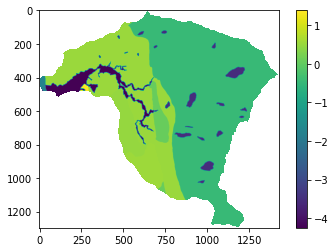

In [ ]:
plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Finalmente se calcula el Indice de Susceptibildiad (IS), el cual corresponde a la suma de los mapas reclasificados con el valor del Contraste, de la siguiente forma.

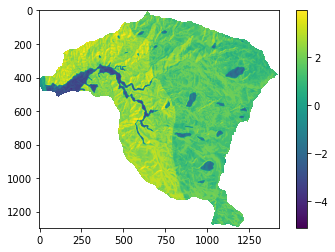

In [ ]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### *Evidential Belief Funtion* (EBF)
El modelo EBF (Dempster - Shafer) consiste en el grado de *Belief* (Bel), *Disbelief* (Dis), *Uncertainty* (Unc) y *Plausibility* (Pls), con valores entre 0 y 1. Bels y Pls representan el límite de probabilidad Bayesiana inferior y superior. Mientras que, Pls es mayor o igual que Bel, y Unc es la diferencia entre ellos, indicando la incertidumbre del resultado.

$Wc_{ij}L=\frac{N(c \cap L)/N(c)}{N(L)-N(c \cap L)/N(S)-N(c)}$

$Belc_{ij}=\frac{Wc_{ij}L}{\sum{Wc_{ij}L}}$
						
$Wc_{ij} \bar L=\frac{N(c)-N(c \cap L)/N(c)}{N(S)-N(L)-N(c)-N(c \cap L)/N(S)-N(c)}$

$Disc_{ij}=\frac{Wc_{ij} \bar L}{\sum{Wc_{ij} \bar L}}$
						
$Uncc_{ij}=1-Belc_{ij} - Disc_{ij}$

:::{figure-md} ebf
<img src="https://www.researchgate.net/profile/Hossein-Nazmfar-2/publication/234059633/figure/fig5/AS:637397922508801@1528978915684/Schematic-relationships-of-evidential-belief-functions-Althuwaynee-et-al-2012.png" alt="ebf" width="600px">

Método *Evidential Belief Funtion*.
:::

:::{figure-md} ebf1
<img src="https://i.pinimg.com/564x/4c/90/c3/4c90c30f26e6385e74bb00899a4f7110.jpg" alt="ebf1" width="400px">

Ejemplo del cálculo de *Evidential Belief Funtion*.
:::

#### *Python*

Para calcular el *Belief* de las 5 clases de la variable *pendiente* se utiliza:

In [ ]:
a=(ap1/ap)/((total1-ap1)/(total-ap))
b=(bp1/bp)/((total1-bp1)/(total-bp))
c=(cp1/cp)/((total1-cp1)/(total-cp))
d=(dp1/dp)/((total1-dp1)/(total-dp))
e=(ep1/ep)/((total1-ep1)/(total-ep))

b_a=a/(a+b+c+d+e)
b_b=b/(a+b+c+d+e)
b_c=c/(a+b+c+d+e)
b_d=d/(a+b+c+d+e)
b_e=e/(a+b+c+d+e)

print("Belief:", b_a, b_b, b_c, b_d, b_e)

Belief: 0.028636888599459454 0.08836979630596908 0.17057727386806315 0.24158277681574458 0.4708332644107637


El *Disbelief* para cada una de las clases de la variable *pendiente* se calcula de la siguiente forma:

In [ ]:
a=((ap-ap1)/ap)/((total-total1-ap-ap1)/(total-ap))
b=((bp-bp1)/bp)/((total-total1-bp-bp1)/(total-bp))
c=((cp-cp1)/cp)/((total-total1-cp-cp1)/(total-cp))
d=((dp-dp1)/dp)/((total-total1-dp-dp1)/(total-dp))
e=((ep-ep1)/ep)/((total-total1-ep-ep1)/(total-ep))

d_a=a/(a+b+c+d+e)
d_b=b/(a+b+c+d+e)
d_c=c/(a+b+c+d+e)
d_d=d/(a+b+c+d+e)
d_e=e/(a+b+c+d+e)

print("Disbelief:", d_a, d_b, d_c, d_d, d_e)

Disbelief: 0.20007080858308765 0.20003011952439112 0.20008850944212533 0.19986765910484464 0.1999429033455513


Finalmente *Uncertainty* se obtiene de:

In [ ]:
U_a=1-b_a-d_a
U_b=1-b_b-d_b
U_c=1-b_c-d_c
U_d=1-b_d-d_d
U_e=1-b_e-d_e

print("Uncertainty:", U_a, U_b, U_c, U_d, U_e)

Uncertainty: 0.7712923028174529 0.7116000841696398 0.6293342166898116 0.5585495640794108 0.329223832243685


En este caso se utilizará el *Belief* para calcular el mapa de susceptibilidad, por lo tantos se reclasifica la clase con dicho valor:

[0.02863689 0.08836979 0.17057727 0.24158278 0.47083327        nan]


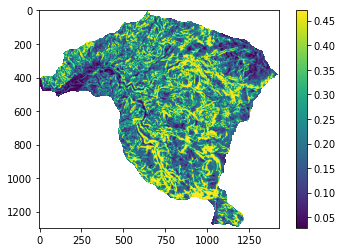

In [ ]:
pendiente_c=np.where ( (np.logical_and (pendiente>=0, pendiente<10 )),b_a,pendiente )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=10, pendiente_c<20 )),b_b,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=20, pendiente_c<30 )),b_c,pendiente_c )
pendiente_c=np.where ( (np.logical_and (pendiente_c>=30, pendiente_c<35 )),b_d,pendiente_c )
pendiente_c=np.where ( pendiente_c>=35,b_e,pendiente_c )

plt.imshow(pendiente_c)
plt.colorbar()
print(np.unique(pendiente_c));

Se realiza el mismo procedimiento para la variable *aspecto*:

Belief: 0.22059904091496013 0.4376299292348657 0.17536859361505716 0.16640243623511694
Disbelief: 0.2499120549717284 0.2496030526973982 0.25022155993041695 0.25026333240045645
Uncertainty: 0.5294889041133115 0.31276701806773605 0.5744098464545259 0.5833342313644265
[-1.          0.16640243  0.17536859  0.22059904  0.43762994         nan]


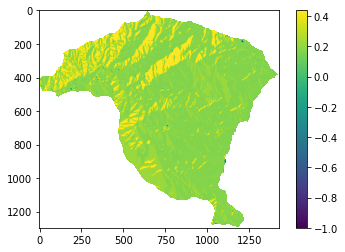

In [ ]:
a=(aa1/aa)/((total1-aa1)/(total-aa))
b=(ba1/ba)/((total1-ba1)/(total-ba))
c=(ca1/ca)/((total1-ca1)/(total-ca))
d=(da1/da)/((total1-da1)/(total-da))

b_a=a/(a+b+c+d)
b_b=b/(a+b+c+d)
b_c=c/(a+b+c+d)
b_d=d/(a+b+c+d)

print("Belief:", b_a, b_b, b_c, b_d)

a=((aa-aa1)/aa)/((total-total1-aa-aa1)/(total-aa))
b=((ba-ba1)/ba)/((total-total1-ba-ba1)/(total-ba))
c=((ca-ca1)/ca)/((total-total1-ca-ca1)/(total-ca))
d=((da-da1)/da)/((total-total1-da-da1)/(total-da))

d_a=a/(a+b+c+d)
d_b=b/(a+b+c+d)
d_c=c/(a+b+c+d)
d_d=d/(a+b+c+d)

print("Disbelief:", d_a, d_b, d_c, d_d)

U_a=1-b_a-d_a
U_b=1-b_b-d_b
U_c=1-b_c-d_c
U_d=1-b_d-d_d

print("Uncertainty:", U_a, U_b, U_c, U_d)

aspecto_c=np.where ( (np.logical_and (aspecto>=0, aspecto<90 )),b_a,aspecto )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=90, aspecto_c<180 )),b_b,aspecto_c )
aspecto_c=np.where ( (np.logical_and (aspecto_c>=180, aspecto_c<270 )),b_c,aspecto_c )
aspecto_c=np.where ( aspecto_c>=270,b_d,aspecto_c )

plt.imshow(aspecto_c)
plt.colorbar()
print(np.unique(aspecto_c));

Para la variable *geologia* se desarrolla de la siguiente forma:

Belief: 0.11993272791080681 0.23185865586455962 0.012764558792757978 0.12179228309911387 0.0009976325032969371 0.0753178650016471 0.11400254469808202 0.04437665002700843 0.27689117676463276 0.0020659053380944732
Disbelief: 0.10008379504116847 0.09959506656154726 0.10015572352634632 0.09990201784339821 0.10019292592535327 0.10000483055392438 0.09992656286467365 0.1004673598751549 0.09948551776136504 0.1001862000470683
Uncertainty: 0.7799834770480247 0.6685462775738931 0.8870797176808958 0.7783056990574879 0.8988094415713498 0.8246773044444285 0.7860708924372444 0.8551559900978367 0.6236233054740022 0.8977478946148372
[0.00099763 0.00206591 0.01276456 0.04437665 0.07531787 0.11400254
 0.11993273 0.12179228 0.23185866 0.27689118        nan]


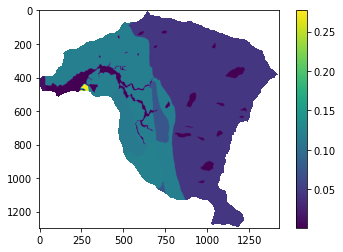

In [ ]:
a=(ag1/ag)/((total1-ag1)/(total-ag))
b=(bg1/bg)/((total1-bg1)/(total-bg))
c=(cg1/cg)/((total1-cg1)/(total-cg))
d=(dg1/dg)/((total1-dg1)/(total-dg))
e=(eg1/eg)/((total1-eg1)/(total-eg))
f=(fg1/fg)/((total1-fg1)/(total-fg))
g=(gg1/gg)/((total1-gg1)/(total-gg))
h=(hg1/hg)/((total1-hg1)/(total-hg))
i=(ig1/ig)/((total1-ig1)/(total-ig))
j=(jg1/jg)/((total1-jg1)/(total-jg))


b_a=a/(a+b+c+d+e+f+g+h+i+j)
b_b=b/(a+b+c+d+e+f+g+h+i+j)
b_c=c/(a+b+c+d+e+f+g+h+i+j)
b_d=d/(a+b+c+d+e+f+g+h+i+j)
b_e=e/(a+b+c+d+e+f+g+h+i+j)
b_f=f/(a+b+c+d+e+f+g+h+i+j)
b_g=g/(a+b+c+d+e+f+g+h+i+j)
b_h=h/(a+b+c+d+e+f+g+h+i+j)
b_i=i/(a+b+c+d+e+f+g+h+i+j)
b_j=j/(a+b+c+d+e+f+g+h+i+j)


print("Belief:", b_a, b_b, b_c, b_d, b_e, b_f, b_g, b_h, b_i, b_j)

a=((ag-ag1)/ag)/((total-total1-ag-ag1)/(total-ag))
b=((bg-bg1)/bg)/((total-total1-bg-bg1)/(total-bg))
c=((cg-cg1)/cg)/((total-total1-cg-cg1)/(total-cg))
d=((dg-dg1)/dg)/((total-total1-dg-dg1)/(total-dg))
e=((eg-eg1)/eg)/((total-total1-eg-eg1)/(total-eg))
f=((fg-fg1)/fg)/((total-total1-fg-fg1)/(total-fg))
g=((gg-gg1)/gg)/((total-total1-gg-gg1)/(total-gg))
h=((hg-hg1)/hg)/((total-total1-hg-hg1)/(total-hg))
i=((ig-ig1)/ig)/((total-total1-ig-ig1)/(total-ig))
j=((jg-jg1)/jg)/((total-total1-jg-jg1)/(total-jg))


d_a=a/(a+b+c+d+e+f+g+h+i+j)
d_b=b/(a+b+c+d+e+f+g+h+i+j)
d_c=c/(a+b+c+d+e+f+g+h+i+j)
d_d=d/(a+b+c+d+e+f+g+h+i+j)
d_e=e/(a+b+c+d+e+f+g+h+i+j)
d_f=f/(a+b+c+d+e+f+g+h+i+j)
d_g=g/(a+b+c+d+e+f+g+h+i+j)
d_h=h/(a+b+c+d+e+f+g+h+i+j)
d_i=i/(a+b+c+d+e+f+g+h+i+j)
d_j=j/(a+b+c+d+e+f+g+h+i+j)

print("Disbelief:", d_a, d_b, d_c, d_d, d_e, d_f, d_g, d_h, d_i, d_j)

U_a=1-b_a-d_a
U_b=1-b_b-d_b
U_c=1-b_c-d_c
U_d=1-b_d-d_d
U_e=1-b_e-d_e
U_f=1-b_f-d_f
U_g=1-b_g-d_g
U_h=1-b_h-d_h
U_i=1-b_i-d_i
U_j=1-b_j-d_j

print("Uncertainty:", U_a, U_b, U_c, U_d, U_e, U_f, U_g, U_h, U_i, U_j)

geologia_c=np.where ( geologia==2,b_a,geologia )
geologia_c=np.where ( geologia_c==4,b_b,geologia_c )
geologia_c=np.where ( geologia_c==6,b_c,geologia_c )
geologia_c=np.where ( geologia_c==8,b_d,geologia_c )
geologia_c=np.where ( geologia_c==9,b_e,geologia_c )
geologia_c=np.where ( geologia_c==10,b_f,geologia_c  )
geologia_c=np.where ( geologia_c==11,b_g,geologia_c  )
geologia_c=np.where ( geologia_c==14,b_h,geologia_c  )
geologia_c=np.where ( geologia_c==15,b_i,geologia_c  )
geologia_c=np.where ( geologia_c==16,b_j,geologia_c  )

plt.imshow(geologia_c)
plt.colorbar()
print(np.unique(geologia_c));

Con los mapas de cada variable reclasificados de acuerdo con el valor de *Belief* se procede entonces a sumar todas las variables y obtener el mapa de susceptibilidad:

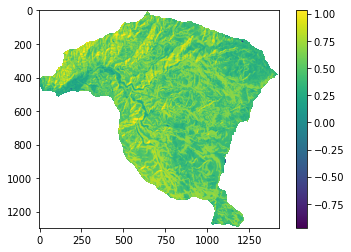

In [ ]:
IS=pendiente_c+aspecto_c+geologia_c
plt.imshow(IS);
plt.colorbar();

### *Certainty Factor* (CF)
El valor de CF varía entre -1 y +1. Un valor positivo significa un incremento en la certidumbre de la ocurrencia de deslizamientos, mientras que un valor negativo corresponde a una reducción en dicha certidumbre. Un valor cercano a 0 significa que la probabilidad priori es muy similar a la probabilidad condicional.

:::{figure-md} cf
<img src="https://i.pinimg.com/originals/ae/1a/55/ae1a558572dffa10393f414d91a5bf24.jpg" alt="cf" width="400px">

Método de *Certainty Factor*.
:::

Donde PPa es la probabilidad condicional de la ocurrencia de un deslizamiento en la clase a. PPs es la probabilidad priori del número total de deslizamientos en el área.

#### *Python*

Los mapas finales los podemos exportar en formato *tif*, para eso en el siguiente ejemplo se utiliza el mapa de pendientes para extraer las dimensiones de la matriz (mapa) a crear de la zoan de estudio.

In [ ]:
meta=raster.profile
raster_transform = meta['transform']
raster_crs = meta['crs']

with rio.open('Desktop/IS.TIF', 'w', 
              driver='Gtiff',height=pendiente.shape[0],width=pendiente.shape[1],count=1,
              dtype='float64',nodata=-999,crs=raster_crs,transform=raster_transform) as dst:
    dst.write(IS,1);

## Multivariados
A diferencia de los métodos estadísticos bivariados, que combinan el inventario de movimientos en masa con cada variable por separado, los métodos estadísticos multivariados evalúan la relación combinada entre la variable dependiente (la ocurrencia de movimientos en masa) y todas variables independientes (variables predictoras) en simultanea. Entre estos métodos se encuentra la regresión logística, la cual ha sido el método mas utilizado alrededor del mundo para evaluar la susceptibilidad por movimientos en masa; al igual que el método de análisis discriminante lineal, el cual es el exigido en los estudios de amenaza en los Planes de Ordenación y Manejo de Cuencas (POMCA) en Colombia. 

Adicionalmente como parte de los métodos multivariados, con la explosión de la era de los datos, se encuentran disponibles técnicas de aprendizaje automático de máquinas (*machine learning*), especificamente los métodos supervisados de clasificación binarios, entre los cuales se encuentran regresión logística y análisis discriminante, pero adicionalmente algoritmos como *support vector machine*, métodos ensamblados tipo *bagging* como *random forest*, tipo boosting como *XGBoost*, y técnicas de *deep learning* como redes neuronales artificiales. 

:::{figure-md} ml
<img src="https://miro.medium.com/max/477/1*KFQI59Yv7m1f3fwG68KSEA.jpeg" alt="ml" width="500px">

Algoritmos utilizados en *machine learning*
:::

Existen métodos paramétricos y no-paramétricos. Los modelos paramétricos simplifican el aprendizaje a partir de los datos de entrenamiento, ya que utilizan una función conocida que generalmente corresponde a una combinación lineal de las variables predictoras. Por lo que como resultado siempre se obtiene los coeficientes de la función predeterminada. Estos modelos además de no exigir una gran capacidad computacional, son muy estables sin presentar problemas de varianza. Sin embargo, en muchos casos el problema a modelar no se ajusta a una función lineal, por lo que pueden presentar problemas de ajuste o sesgo. Para estos casos se recomienda el uso de modelos no paramétricos, ya que no asumen ninguna forma previa de la función objetivo, permitiendo aprender en teoría a partir de los datos de entrenamiento cualquier forma de la función. Generalmente no presentan problemas de ajuste o sesgo, pero en su defecto tienden a sobre ajustarse a los datos, generando problemas de varianza ante nuevas observaciones. En este sentido, un buen modelo se soporta en un balance entre el ajuste y la varianza, desafortunadamente mejorar en uno de estos aspectos implica generalmente reducción en el otro.

Entre las limitaciones que presentan los métodos estadísticos multivariados se encuentra que los resultados implican que los movimientos en masa ocurren por la misma combinación de factores a lo largo del área de estudio. Esta generalización ignora el hecho que la ocurrencia de ciertos tipos de movimientos en masa están controlados por ciertos factores de causa que deben ser analizados o investigados individualmente.

A continuación se describen cada uno de los métodos mas comúnes. Inicialmente se describe el método denominado *análisis condicional*, el cual es el único de los métodos que no se considera una técnica de *machine learning*. Posteriormente se procederá a presentar los métodos de *machine learning* utilizados para evaluar la susceptibilidad por movimientos en masa.

### Método de análisis condicional
El método de análisis condicional, o también denominado *matrix assessment* fue desarrollado por {cite:t}`Clerici2002`, y no requiere asunciones de aleatoriedad del fenómeno bajo análisis. En general es utilizado por su simpleza conceptual y matemática, sin embargo desde el punto de vista procedimental puede ser demandante.

Se fundamente en el uso de la unidad de análisis denominada Unidad de Condiciones Unicas (UCU). El procedimiento es el siguiente: (i) elaborar el mapa de UCU a partir de las variables predictoras seleccionadas, (ii) se cruza el mapa de UCU con el inventario de movimientos en masa, (iii) se calcula para cada UCU el porcentaje de área con movimientos en masa, (iv) finalmente, se clasifican de acuerdo con el porcentaje de área afectada. Ese porcentaje, que corresponde a una densidad relativa, es equivalente a la probabilidad futura de la ocurrencia de movimientos en masa.

:::{figure-md} metodo ucu
<img src="https://i.pinimg.com/564x/cc/6d/00/cc6d00fc1e76c817cac53b08377c25b2.jpg" alt="metodo ucu" width="500px">

Método de análisis condicional. Tomado de Urquia et al., (2020).
:::


### Regresión logística
El método estadístico multivariado denominado regresión logística (RL) estima la relación de una variable dependiente categórica (la ocurrencia de movimientos en masa) de valores binarios de 0 (no ocurrencia) y 1 (si ocurrencia), con un grupo de variables independientes, en este caso las variables condicionantes del terreno. De esta forma, la RL se utiliza para clasificar a qué grupo, ocurrencia=1 ó no-ocurrencia=0, pertenece una observación en función de diferentes variables predictoras. Para esto la RL estima la probabilidad de *y* de pertenecer a cada grupo transformando la combinación lineal de las variables predictoras (*x*) mediante la función *logit* o *sigmoid*. Lo que le permite transformar los valores arrojados por la combinación lineal a un dominio entre 0 y 1. La función *logit* se define como el logaritmo natural de la relación entre la probabilidad de ocurrencia y la probabilidad de no ocurrencia, también denominada *odds*

$P(y/x) = \frac{1}{1+e^{-z}}$
			
$\frac{p(y/x)}{1-p(y/x)} = e^{a+\sum bx}$
						
$Ln(\frac{p(y/x)}{1-p(y/x)}) = a+\sum bx$

Donde $P(y/x)$ es la probabilidad que *y* sea igual a 1, es decir la ocurrencia de movimientos en masa, dado la combinación lineal de las variables independientes:

$z=\beta_o+\beta_1X_1+\beta_2X_2+\beta_3X_3+...+\beta_nX_n$

Donde $\beta_0$ es el intercepto del modelo, los valores $\beta_i$ (i=1,2, 3, n) son los coeficientes de la regresión logística, es decir, los pesos de las variables, y los valores $X_i$ (i=1, 2, 3,..., n) son las variables independientes. El resultado final es un valor entre 0 y 1, donde 0 es la probabilidad nula de ocurrencia de movimientos en masa y 1 la máxima probabilidad de ocurrencia. De acuerdo con esto, a pesar de que el modelo transformado es lineal en las variables, las probabilidades no son lineales.

La ventaja de la RL es que las variables predictoras no requieren tener distribución normal y pueden ser discretas o continuas, o una combinación de ambas. Sin embargo, para incorporar variables categóricas se deben transformar a variables binarias todas las clases, es decir una nueva variable por cada clase. El modelo en este caso elimina una clase, que pasa a ser la clase referente, y arroja un coeficiente para las demas clases. Es decir que los coeficientes de las clases se interpretan con respecto a la clase faltante. Esta eliminación de una clase se realiza con el objeto de evitar la multicolinealidad entre variables, ya que todas las clases sumadas dan como resultado un vector constante igual a 1, es decir que se correlacionan perfectamente.


:::{figure-md} rl0
<img src="https://i0.wp.com/www.jacobsoft.com.mx/wp-content/uploads/2018/10/grafica-sigmoi.png?resize=800%2C420&ssl=1" alt="rl0" width="600px">

Función logística.
:::

A continuación se presenta un ejemplo de la estimación del coeficiente de la regresión logística para un problema de la ocurrencia o no de movimientos en masa dada dado una sola variable, la pendiente, clasificada en dos clases, pendientes $<20°$ y pendientes $>20°$. 

:::{figure-md} rl1
<img src="https://i.pinimg.com/564x/59/ce/fe/59cefecb396127fa7252a395c30eb23f.jpg" alt="rl1" width="500px">

Ejemplo 1 regresión logística.
:::

El coeficiente estimado es $-0.46$, el cual se obtiene a partir del logaritmo natural de la relación entre los *odds* de la clase pendientes $>20°$ con respecto a la ocurrencia de movimientos en masa y los *odds* de clase pendientes $<20°$. Los *odds* para cada clase de pendiente corresponde a la probabilidad de ocurrencia de movimientos en masa en dicha clase sobre la probabilidad de no ocurrencia.

En el siguiente ejemplo se presentan los resultados tanto para el coeficiente de la pendiente como el intercepto, lo que permite construir la combinación lineal y estimar la probabilidad de ocurrencia de un movimiento en masa cuando la pendiente es $>20°$ o cuando es $<20°$. Para estimar esta probabilidad solo se debe reemplazar en la función *sigmoid* el valor de *x* por 1, cuando la pendiente es $>20°$, o por el valor de 0 cuando la pendiente es $<20°$.

:::{figure-md} rl2
<img src="https://i.pinimg.com/564x/61/e3/8f/61e38fb081e8b0638a090514b2550f6b.jpg" alt="rl2" width="500px">

Ejemplo 2 regresión logística.
:::

Como se puede observar, cuando se aplica la función *e* al coeficiente de la pendiente se obtiene los *odds*, es decir la probabilidad de ocurrencia de movimientos en masa dado que la pendiente sea $>20°$  sobre la probabilidad de ocurrencia de movimientos en masa dado que la pendiente sea $<20°$. En este caso que el valor obtenido es 0.63 significa que es mas probale la ocurrencia para celdas con pendiente $<20°$.

#### *Python*

A continuación se implementará el método de RL para evaluar la susceptibilidad por movimientos en masa. En este ejemplo sólo se utilizarán tres variables (*pendiente*, *aspecto* y *geologia*).

El primer paso es crear un *Dataframe* con todas las variables y el inventario. A partir de este *Dataframe* se construye un vector con la variable *y* (ocurrencia o no de movimientos en masa), que permitirá entrenar el modelo de *RL*, y otro *Dataframe* con solo las variables predictoras.

In [ ]:
from pandas import DataFrame
d={'inventario':inventario_vector_MenM,'pendiente':pendiente_vector_MenM,'aspecto':aspecto_vector_MenM,'geologia':geologia_vector_MenM}
df = pd.DataFrame(d)
df.head()

,inventario,pendiente,aspecto,geologia
0,0.0,10.862183,208.523560,14.0
1,0.0,12.265345,207.437332,14.0
2,0.0,12.469252,202.684647,14.0
3,0.0,13.148026,211.619766,14.0
4,0.0,14.091524,220.028976,14.0


Lo primero que se recomienda es normalizar los valores. La RL es un algoritmo geometrico sensible a las unidades de cada variable.

In [ ]:
var_names2=['aspecto','pendiente']
for var in var_names2:
    df[var]=(df[var]-df[var].mean())/df[var].std()
df.head()

,inventario,pendiente,aspecto,geologia
0,0.0,-1.582421,-0.051931,14.0
1,0.0,-1.460616,-0.062760,14.0
2,0.0,-1.442916,-0.110142,14.0
3,0.0,-1.383993,-0.021063,14.0
4,0.0,-1.302091,0.062773,14.0


Existen dos librerias que nos permiten resolver este modelo, *statsmodels* y *sklearn*. La primera de ellas nos ofrece un resumen con los resultados y métricas de desempeño del modelo y utilizar la libreria Patsy que permite el uso de formulas.

In [ ]:
import statsmodels.formula.api as sfm
lr   = sfm.logit(formula = "inventario ~ pendiente + C(geologia)", data = df).fit()
print(lr.summary())

         Current function value: 0.012661
         Iterations: 35


c:\Users\edier\miniconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:             inventario   No. Observations:               910801
Model:                          Logit   Df Residuals:                   910790
Method:                           MLE   Df Model:                           10
Date:                Sun, 06 Nov 2022   Pseudo R-squ.:                 0.02902
Time:                        19:00:09   Log-Likelihood:                -11532.
converged:                      False   LL-Null:                       -11876.
Covariance Type:            nonrobust   LLR p-value:                1.220e-141
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.0824      0.042   -143.463      0.000      -6.166      -5.999
C(geologia)[T.4.0]     -9.0341    157.190     -0.057      0.954    -317.122     299.054
C(geologia)[T.6.

La librearia *statsmodels* incorpora por defecto el intercepto en el modelo y en las formulas pueden especificar el tipo de variables categóricas con una *C*. Como se menciono anteriormente las clases de las variables categoricas son transformadas en variables binarias, eliminando una. En este caso se elimino la clase 2 de *geologia*, por lo que los coeficientes de las demas clases son con respecto a dicha clase. Entre los resultados se destacan el estimador para los coeficientes (maxima verosimilitud -MLE-), el logaritmo del estimador MLE (Log-likelihood), el coeficiente de ajuste (Pseudo R-squ.). Con respecto a los coeficientes se presenta el valor de la prueba de hipotesis nula que el valor del coeficiente es igual a cero (z) como el valor del coeficiente entre el error estandar (std err), y el *p-value* (P>|z|), este valor debe ser menor al 5% (0.05), lo cual significa que la probabilidad que el coeficiente tenga un valor de 0 es muy bajo.  Finalmente se presenta el rango del 95% del dominio del valor del coeficiente.

La libreria  *scikit learn* permite parametrizar el modelo de diferentes formas, sin embargo requiere ingresar entre variables dependientes y variables independientes. Asi como transformar la variable categorica.

In [ ]:
X=df.drop("inventario", axis=1)
y=df['inventario']
X.head()

,pendiente,aspecto,geologia
0,-1.582421,-0.051931,14.0
1,-1.460616,-0.062760,14.0
2,-1.442916,-0.110142,14.0
3,-1.383993,-0.021063,14.0
4,-1.302091,0.062773,14.0


In [ ]:
dummy_geologia=pd.get_dummies(X['geologia'],prefix='geo')
column_name=X.columns.values.tolist()
column_name.remove('geologia')
X1=X[column_name].join(dummy_geologia)
X1.head()

,pendiente,aspecto,geo_2.0,geo_4.0,geo_6.0,geo_8.0,geo_9.0,geo_10.0,geo_11.0,geo_14.0,geo_15.0,geo_16.0
0,-1.582421,-0.051931,0,0,0,0,0,0,0,1,0,0
1,-1.460616,-0.062760,0,0,0,0,0,0,0,1,0,0
2,-1.442916,-0.110142,0,0,0,0,0,0,0,1,0,0
3,-1.383993,-0.021063,0,0,0,0,0,0,0,1,0,0
4,-1.302091,0.062773,0,0,0,0,0,0,0,1,0,0


Inicialmente, se importa la función para RL, y se construye el modelo con los hiperparámetros. En este caso, estamos asignándole un *class_weight* = balanced para que asigne mas peso a las celdas minoritarias, en este caso las celdas donde y=1. De esta forma RL nos ayuda a resolver el problema de la base de datos original  desbalanceada. El segundo hiperparámetro que utilizamos es el tipo de algoritmo para resolver la RL, en este caso utilizaremos *newton-cg*. La librera "skilearn" utiliza por defecto el hiperparametro *fit_intercept* con un valor de *True* que equivale a incluir el intercepto.

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(class_weight='balanced', solver='newton-cg')
model

LogisticRegression(class_weight='balanced', solver='newton-cg')

Luego de tener el modelo construido, se le asignan los datos con la función *fit*, en este caso, primero la matriz con las variables predictoras, y luego la variable *y*. De esta forma el modelo se entrena con los datos y se pueden obtener los resultados de los valores de los coeficientes con la función *coef_*

In [ ]:
result=model.fit(X1,y)
print(result.coef_)

[[ 5.08853286e-01 -4.99256806e-03  2.53241713e+00 -1.56157800e+00
  -3.55555293e+00  2.57767799e+00 -5.35636481e+00  2.16197921e+00
   2.64123695e+00  1.92882797e+00  3.89784550e+00 -5.26648901e+00
  -4.72219096e-10]]


Con el modelo entrenado y guardado en la varible *result* podemos entonces obtener los valores que predice el modelo para toda la matriz con las variables predictoras. Para eso se utiliza la función *predict*. Esta función clasifica cada celda como inestable (1) o estable (0).

In [ ]:
y_pred=result.predict(X1)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Sin embargo, tambien se puede obtener los resultados del modelo antes de clasificarlo como (0,1). es decir la probabilidad de cada celda de ser 0 o de ser 1. Para eso se utiliza la función *predict_proba*. La cual puede ser mas útil para nuestro mapa.

In [ ]:
y_prob=result.predict_proba(X1)
y_prob

array([[0.76194427, 0.23805573],
       [0.75050993, 0.24949007],
       [0.74877512, 0.25122488],
       ...,
       [0.58721003, 0.41278997],
       [0.61585348, 0.38414652],
       [0.61585006, 0.38414994]])

como se puede observar el resultado en este caso, en lugar de ser un vector con la clasificacion de cada celda, es un matriz de dos columnas. Donde la primera columna es la probabilidad de cada celda de ser 0, es decir estable, y la segudna columna la probabilidad de ser 1, es decir inestable. Para nuestro propósito es mas útil obtener la probabilidad de cada celda de ser inestable. Para eso seleccionamos entonces solo la segunda columna de la matriz obtenida.

In [ ]:
y_probs=result.predict_proba(X1)[:,1]
y_probs

array([0.23805573, 0.24949007, 0.25122488, ..., 0.41278997, 0.38414652,
       0.38414994])

Ya tenemos los resultados y la predicción para todas las celdas. Sin embargo esto lo tenemos para un vector que construimos la principio que solo contiene las celdas dentro de la cuenca, es decir eliminó todas las celdas por fuera. Eso nos impide construir nuestra cuenca a partir de este vector.

Una forma de resolver esto se presenta a continuación. Existen muchas formas, seguramente otras mas directas.

Para este caso construiremos entonces un nuevo *Dataframe*, pero en este caso con el vector completo, sin eliminar las celdas por fuera de la cuenca, y las celdas por fuera de la cuenca, en lugar de tener un valor de NaN les daremos un valor de 0. Las funciones de *sklearn* no corren cuando encuentra dentro de los valores NaN.

De igual forma, hay que transformar las variables categóricas a variables tipo *dummy* y en este caso debemos eliminar un anueva columna que se forma con el intercepto y que denomina *0.0*

In [ ]:
pendiente_vector2=np.nan_to_num(pendiente_vector)
aspecto_vector2=np.nan_to_num(aspecto_vector)
geologia_vector2=np.nan_to_num(geologia_vector)

In [ ]:
f={'pendiente':pendiente_vector2,'aspecto':aspecto_vector2,'geologia':geologia_vector2}
x_map=pd.DataFrame(f)
dummy_geologia=pd.get_dummies(x_map['geologia'],prefix='geo')
column_name=x_map.columns.values.tolist()
column_name.remove('geologia')
x_map=x_map[column_name].join(dummy_geologia)
x_map=x_map.drop('geo_0.0',axis=1)

,pendiente,aspecto,geo_2.0,geo_4.0,geo_6.0,geo_8.0,geo_9.0,geo_10.0,geo_11.0,geo_14.0,geo_15.0,geo_16.0,intercepto
0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854705,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
1854706,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
1854707,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1
1854708,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1


Como se puede observar, tenemos ahora una matriz con todas las variables y con un número mayor de celdas.

Con esta matriz podemos entonces obtener para cada celda la probabilidad que se inestable.

In [ ]:
y_pred=model.predict_proba(x_map)[:,1]

Ya lo unico que nos queda es reconstruir a partir de dicho vector la matriz que conforma la cuenca con los valores de susceptibilidad. Para eso utilizaremos como máscara el mapa de pendiente.

In [ ]:
raster = rio.open('https://github.com/edieraristizabal/Libro_cartoGeotecnia/blob/master/data/miel/Pendiente.tif?raw=true')
pendiente=raster.read(1)

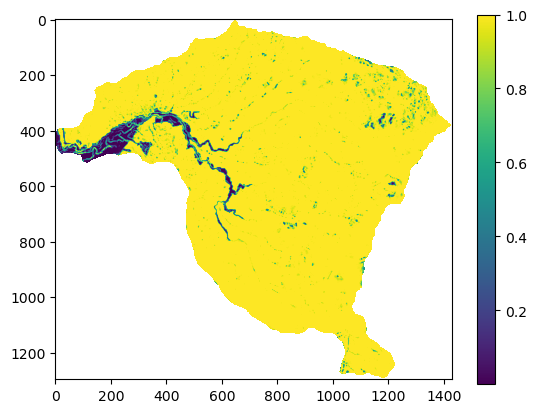

In [ ]:
IS=y_pred.reshape(pendiente.shape)
IS=np.where(pendiente<0,np.nan,IS)
plt.imshow(IS)
plt.colorbar();

### Análisis discriminante lineal
El análisis discriminante lineal (LDA) es una técnica estadística que crea una función capaz de clasificar los fenómenos, teniendo en cuenta una serie de variables discriminadoras y una probabilidad de pertenencia. LDA encuentra combinaciones lineales de variables que mejor “discriminan” las clases de la variable respuesta. LDA supone que las variables predictoras son variables aleatorias continuas normalmente distribuidas y con la misma varianza.

El enfoque de Fisher para LDA es encontrar una combinación lineal de predictores que maximice la matriz de covarianza entre grupos,  relativo a la matriz de covarianza dentro del grupo (intra-grupo). La solución a este problema de optimización es el vector propio correspondiente al valor propio más grande de  $W^{-1}B$ . Este vector es un discriminante lineal (e.g. una variable). Resolver para la configuración para dos grupos la función discriminante $S^{-1}(X_1-X_2)$ donde  $S^{-1}$  es la inversa de la matriz de covarianza de los datos y  $X_1$ y $X_2$ son las medias de cada predictor en los grupos de respuesta 1 y 2. En la práctica, una nueva muestra, $u$, se proyecta sobre la función discriminante como  $uS^{-1}(X_1-X_2)$, que devuelve una puntuación discriminante. Luego, una nueva muestra se clasifica en el grupo 1 si la muestra está más cerca de la media del grupo 1 que de la media del grupo 2 en la proyección.

:::{figure-md} lda
<img src="https://1.bp.blogspot.com/-ODry-XJ159E/Vc9ZRXVvnwI/AAAAAAAABuc/FpSIJdTrqK0/s1600/Analisis-Discriminante-001.png" alt="lda" width="400px">

Intrepretación geométrica de LDA. Tomado de [Plepso](https://plepso.blogspot.com/2015/08/analisis-discriminante-de-dos-grupos.html)
:::

#### *Python*

El procedimiento para todos los métodos de *machine learning* con *sklearn* son muy similares. Se importa la librería, se instancia el modelo con los [hiperparámetros](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) deseados, en este caso vamos a proyectar los datos sobre un nuevo eje (función discriminante), se entrena el modelo, y se predice.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis(n_components=1)
LDA

LinearDiscriminantAnalysis(n_components=1)

In [ ]:
model = LDA.fit(X,y)

Para obtener el mapa se realiza la predicción con el *Dataframe* que tiene todos las celdas, y luego se redimensiona este vector a la matriz que forma la cuenca, utilizando como máscara el mapa de pendiente. Pero para esto debemos contruir un *Dataframe* con todas las celdas pero que en este caso sin la transformación de la variable *geologia*. Estos modelos permiten trabajar con variables categóricas sin transformación.

In [ ]:
f={'pendiente':pendiente_vector2,'aspecto':aspecto_vector2,'geologia':geologia_vector2}
x_map=pd.DataFrame(f)
x_map

,pendiente,aspecto,geologia
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
1854705,0.0,0.0,0.0
1854706,0.0,0.0,0.0
1854707,0.0,0.0,0.0
1854708,0.0,0.0,0.0


In [ ]:
IS=model.predict(x_map)

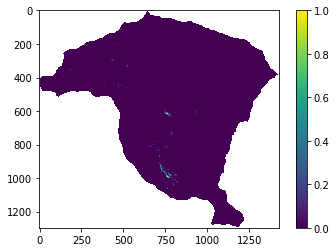

In [ ]:
IS=IS.reshape(pendiente.shape)
IS=np.where(pendiente<0,np.nan,IS)
plt.imshow(IS)
plt.colorbar();

### *Support vector machine*

SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

Los vectores de soporte son los puntos que definen el margen máximo de separación del hiperplano que separa las clases. Se llaman vectores, en lugar de puntos, porque estos «puntos» tienen tantos elementos como dimensiones tenga nuestro espacio de entrada. Es decir, estos puntos multi-dimensionales se representan con con vector de n dimensiones.

:::{figure-md} svm
<img src="https://www.iartificial.net/wp-content/uploads/2019/04/Clasificacion-SVM-768x436.webp" alt="svm" width="400px">

Intrepretación geométrica de SVM. Tomado de [iartificial.net](https://www.iartificial.net/maquinas-de-vectores-de-soporte-svm/)
:::

El *Maximal Margin Classifier* tiene poca aplicación práctica, ya que rara vez se encuentran casos en los que las clases sean perfecta y linealmente separables. De hecho, incluso cumpliéndose estas condiciones ideales, en las que exista un hiperplano capaz de separar perfectamente las observaciones en dos clases, esta aproximación sigue presentando dos inconvenientes:

* Dado que el hiperplano tiene que separar perfectamente las observaciones, es muy sensible a variaciones en los datos. Incluir una nueva observación puede suponer cambios muy grandes en el hiperplano de separación (poca robustez).

* Que el maximal margin hyperplane se ajuste perfectamente a las observaciones de entrenamiento para separarlas todas correctamente suele conllevar problemas de overfitting.

Por estas razones, es preferible crear un clasificador basado en un hiperplano que, aunque no separe perfectamente las dos clases, sea más robusto y tenga mayor capacidad predictiva al aplicarlo a nuevas observaciones (menos problemas de overfitting). Esto es exactamente lo que consiguen los clasificadores de vector soporte, también conocidos como soft margin classifiers o Support Vector Classifiers. Para lograrlo, en lugar de buscar el margen de clasificación más ancho posible que consigue que las observaciones estén en el lado correcto del margen; se permite que ciertas observaciones estén en el lado incorrecto del margen o incluso del hiperplano (Tomado de [cienciadedatos.net](https://www.cienciadedatos.net/documentos/34_maquinas_de_vector_soporte_support_vector_machines)).

#### *Python*

Similar a lso casos anteriores, se importa la librearía de SVC, y se instancia. En este caso se utlizará un kernel lineal y un valor de regularizacion de 1xE10. Existen otra serie de hiperparámetros para instanciar el modelo que se pueden consultar en la [guía del usuario](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)

Si se utiliza toda la base de datos, los resultados obtenidos clasifican todas las celdas con valores muy bajos. Esto se debe a que se utilizó para el entrenamiento la matriz desbalanceada, es decir con las celdas del *si* (1) y con todas las celdas del *no* (0). Lo que genera que el modelo no aprenda adecuadamente a predecir los *si*, ya que aprende esencialmente el *no*.

Como este método no tiene un hiperparámetro para manejar esta situación, como RL, entonces debemos remuestrear nuestros datos de entrenamiento de tal forma que se reduzca el desbalance. En este caso utilizaremos el 1% de los *no*.

In [ ]:
df1=df[(df["inventario"]==1) | (df["inventario"]==0).sample(frac=0.01)]
X_01=df1.drop("inventario", axis=1)
y_01=df1['inventario']
df1['inventario'].value_counts()

0.0    9090
1.0    1620
Name: inventario, dtype: int64

El proceso a continuación toma un tiempo considerable, de acuerdo con la capacidad computacional o el ambiente de trabajo que esté utilizando (cuantas celdas tiene su base de datos?...entonces paciencia...o remuestree sus datos).

In [ ]:
model.fit(X_01,y_01)

In [ ]:
IS_01 = model.predict(x_map)

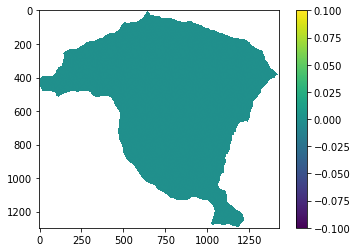

In [ ]:
IS_01=IS_01.reshape(pendiente.shape)
IS_01=np.where(pendiente<0,np.nan,IS_01)
plt.imshow(IS_01)
plt.colorbar();

Como se puede observar, el modelo ya tiene capacidad para predecir los *si* (1).

### *Random forest*
Los árboles de decisión tienen la tendencia de sobre-ajustar (overfit). Esto quiere decir que tienden a aprender muy bien los datos de entrenamiento pero su generalización no es tan buena. Una forma de mejorar la generalización de los árboles de decisión es usar regularización. Para mejorar mucho más la capacidad de generalización de los árboles de decisión, deberemos combinar varios árboles.

Un Random Forest es un conjunto (ensemble) de árboles de decisión combinados con bagging. Al usar bagging, lo que en realidad está pasando, es que distintos árboles ven distintas porciones de los datos. Ningún árbol ve todos los datos de entrenamiento. Esto hace que cada árbol se entrene con distintas muestras de datos para un mismo problema. De esta forma, al combinar sus resultados, unos errores se compensan con otros y tenemos una predicción que generaliza mejor (Tomado de [iartificial.net](https://www.iartificial.net/random-forest-bosque-aleatorio/)).

:::{figure-md} rf
<img src="https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg" alt="rf" width="400px">

Intrepretación geométrica de *random forest**
:::

#### *Python*

De forma similar se importa la librearía, y se instancia con los [hiperparámetros](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) deseados. Igualmente se trabajará solo con el 1% de las celdas del *si* (1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators= 1000)

In [ ]:
rf.fit(X_01, y_01);

In [ ]:
IS_01=rf.predict(x_map)

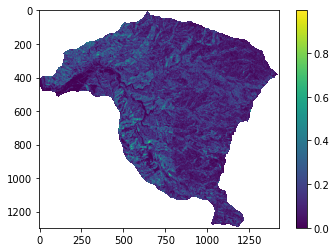

In [ ]:
IS_01=IS_01.reshape(pendiente.shape)
IS_01=np.where(pendiente<0,np.nan,IS_01)
plt.imshow(IS_01)
plt.colorbar();

El modelo de *random forest* permite obtener la importancia de las variables. A continuación se presenta el código para eso:

In [ ]:
print(list(rf.feature_importances_))

[0.47517109325806123, 0.48043670293880586, 0.04439220380313297]


### Redes neuronales
Una red neuronal artificial es un grupo interconectado de nodos similar a la vasta red de neuronas en un cerebro biológico. Cada nodo circular representa una neurona artificial y cada flecha representa una conexión desde la salida de una neurona a la entrada de otra.

:::{figure-md} rna
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/300px-Colored_neural_network_es.svg.png" alt="rna" width="400px">

Intrepretación geométrica de redes neuronales. Tomado de [Wikipedia](https://es.wikipedia.org/wiki/Red_neuronal_artificial)
:::

Cada neurona está conectada con otras a través de unos enlaces. En estos enlaces el valor de salida de la neurona anterior es multiplicado por un valor de peso. Estos pesos en los enlaces pueden incrementar o inhibir el estado de activación de las neuronas adyacentes. Del mismo modo, a la salida de la neurona, puede existir una función limitadora o umbral, que modifica el valor resultado o impone un límite que no se debe sobrepasar antes de propagarse a otra neurona. Esta función se conoce como función de activación. Estos sistemas aprenden y se forman a sí mismos, en lugar de ser programados de forma explícita. Para realizar este aprendizaje automático, normalmente, se intenta minimizar una función de pérdida que evalúa la red en su total. Los valores de los pesos de las neuronas se van actualizando buscando reducir el valor de la función de pérdida. Este proceso se realiza mediante la propagación hacia atrás.

#### *Python*

La librearía *sklearn* permite implementar el *Multi-layer Perceptron classifier* (MLP). Para redes neuronales mas complejas se deben utilizar otras librearías como TensorFlow. Sin embargo MLP permite un importante número de [hiperparámetros](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), tales como el número de capas escondidas y el número de neuronas en cada una, asi como el número de iteracciones que deseamos realice la RNA.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5,2),max_iter=500)  # dos capas escondidas, la primera con 5 neuronas y la segunda con dos neuronas
mlp

MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=500)

Para RNA es importante escalar las variables, para esto utilizamos la función *StandarScaler*:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_01)
X_trans = scaler.transform(X_01)

Finlamente, se entrena el modelo y se predeci.

In [ ]:
mlp.fit(X_01,y_01)

MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=500)

In [ ]:
IS=mlp.predict(x_map)

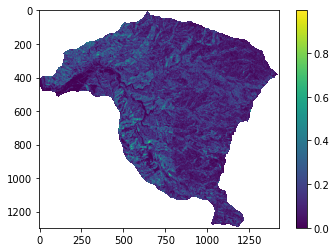

In [ ]:
IS_01=IS_01.reshape(pendiente.shape)
IS_01=np.where(pendiente<0,np.nan,IS_01)
plt.imshow(IS_01)
plt.colorbar();

## Referencias
```{bibliography}
:style: plain
:filter: docname in docnames
```